# Случайные процессы. Прикладной поток.
## Практическое задание 6

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 6"`. Квадратные скобки обязательны. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `6.N.ipynb` и `6.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1. Генерация винеровского процесса

Генерировать траектории винеровского процесса можно двумя способами:

1. На отрезке $[0, 1]$ траектория генерируется с помощью функций Шаудера. Описание данного метода было рассказано на лекции. Его можно найти так же в книге *А.В. Булинский, А.Н. Ширяев - Теория случайных процессов*.

2. На отрезке $[0, \pi]$ траекторию можно с помощью следующей формулы
$$W_t = \frac{\xi_0 t}{\sqrt{\pi}} +\sqrt{\frac{2}{\pi}}\sum\limits_{i=1}^{+\infty} \frac{\sin(kt)}{k} \xi_k,$$
где $\{\xi_n\}$ --- независимые стандартные нормальные случайные величины.

Траектория для $\mathbb{R}_+$ генерируется с помощью генерирования отдельных траекторий для отрезков длины 1 или $\pi$ (в зависимости от метода) с последующим непрерывным склеиванием. 

Генерацию траекторий одним из этих способов вам нужно реализовать. Ваш вариант можете узнать из файла с распределением.

Напишите класс, который будет моделировать винеровский процесс.
Из бесконечной суммы берите первые $n$ слагаемых, где число $n$ соответствует параметру `precision`.
Интерфейс должен быть примерно таким (подчеркивания обязательны!):

_______________________________________________
Будем считать, что всё математическое описание содержится в книге, Булинского-Ширяева, и обозначения в коде будут пытаться соответствовать обозначениям в этой книге. Для поиска значения функций Шаудера посмотрим на график 3.3 на странице 45. (далее - комментарии по коду)

Непрерывная склейка - единственный не описанный в книге шаг, поясним его. Для генерации значений для $t \in [0, T], T \in N$ сгенерируем T траекторий $W^j(t) : = W_t^j$ на отрезках [0,1], после чего $W_t := W(1)^0 + W(1)^1 + ... + W(1)^{\lfloor t \rfloor - 2} + W(1)^{\lfloor t \rfloor - 1} + W(\{ t \})^{\lfloor t \rfloor}$, где $\{ t \}$ - дробная часть ($t = \lfloor t \rfloor + \{ t \}$). Нетрудно показать, учитывая, что $\xi_{ab} + \xi_{bc} \sim N(0, c - a),$ если $ \xi_{ab} \sim N(0, b - a), \xi_{bc} \sim N(0, c - b), a < b < c$ процесс, построенный таким образом, будет удовлетворять определению винеровского процесса.

In [91]:
class WinerProcess:
    def __init__(self, precision=10000):
        self._precision = precision
        self._xi = [sps.norm.rvs(size=self._precision)] 
        # здесь будут \xi_k^t, где t - номер отрезка
        self._starts = [0, self._xi[0][0]]  # значения W_t для целых t
        self._log = False
        
        self._k = [0.5] + list(range(1, self._precision))
        # в нулевое значение напишем что-нибудь, всё равно S_0 будем считать отдельно
        self._n = np.log2(self._k).astype(int)
        self._a_nk = 2.**(- self._n)*(self._k - 2. ** self._n)
        
        # переменные, указанные ниже, используются для ускорения расчётов,
        # их смысл становится понятен после просмотра следующей функции
        # они часто используются, их лучше хранить постоянно
        
        # по сути это координаты x треугольников с рис 3.3 из книги
        self._positive_slope_l_bound = self._a_nk  # копирования не происходит, это python
        self._positive_slope_r_bound = self._a_nk + 2.**(-self._n - 1)
        
        self._negative_slope_l_bound = self._positive_slope_r_bound 
        self._negative_slope_r_bound = self._a_nk + 2.**(-self._n)
        
        # высоты и половинки оснований треугольников
        self._slope_height = 2. ** (- (self._n / 2.) - 1)
        self._slope_half_width = 2. ** (-self._n - 1)
        
        if self._log:
            print("k = {}\n n = {}\n a_nk = {}\n".format(self._k, self._n, self._a_nk))
        
    def __getitem__(self, times):
        times = np.array(times)
        if times.max() >= len(self._xi):
            # выделяем новые xi_i^j - для отрезков [n, n+1], которые
            # ранее не были рассмотрены
            addition = int(times.max() + 1.) - len(self._xi)  # число новых отрезков
            add_xi = sps.norm.rvs(size=(addition, self._precision))
            self._starts += list(self._starts[-1] + np.cumsum(add_xi[:, 0]))
            self._xi += list(add_xi)
            
        W = []  # сюда будет помещать ответ
        for t in times:  # один цикл
            t_fractional_part = t - int(t)  # дробная
            t_integer_part = int(t)  # и целая части t
            
            positive_slope = (
                (self._positive_slope_l_bound <= t_fractional_part)
                & (t_fractional_part <= self._positive_slope_r_bound)
            )
            # булевский вектор индексов positive_slope[k] - верно ли, что y S_k положительная
            # производная (или верхняя вершина треугольника - ф-ии Шаудера (рис 3.3)) в точке t
            # - т.е. мы находимся на "положительном склоне горы" (k>0)
            
            # S_k - k-ая функция Шаудера (согласно книге) 
            
            positive_slope[0] = False  # Sk[0] считается отдельно
             
            negative_slope = (
                (self._negative_slope_l_bound < t_fractional_part)
                & (t_fractional_part <= self._negative_slope_r_bound)
            )
            # аналогично для отрицательной производной "отрицательный склон горы - треугольника"
            # , но исключая "верх" треугольника (он уже был в positive_slope)
            
            Sk_in_positive_slopes = (
                self._slope_height[positive_slope]
                * (t_fractional_part - self._positive_slope_l_bound[positive_slope])
                / self._slope_half_width[positive_slope]
            )
            # вычислим значения только для тех функций, для которые производная 
            # в текущей точке положительна. (по подобию треугольников - см. рис. 3.3)
            
            Sk_in_negative_slopes = (
                self._slope_height[negative_slope]
                * (self._negative_slope_r_bound[negative_slope] - t_fractional_part)
                / self._slope_half_width[negative_slope]
            )
            # аналогично для negative_slopes

            Sk = np.zeros(self._precision)  # всё, кроме подсчитанного выше и S_0 - нули в t
            Sk[positive_slope] = Sk_in_positive_slopes
            Sk[negative_slope] = Sk_in_negative_slopes
            Sk[0] = t_fractional_part  # вычисляем S_0(t) = t (для t \in [0, 1])
             
            if (self._log):
                print("Shauder's function at t = ", t)
                print("positive_slopes = ", positive_slope)
                print("negative_slopes = ", negative_slope)
                print("Sk(t) values = ", Sk)
                         
            """
            Sk = np.zeros(precision)
            Sk[positive_slope] = Sk_in_positive_slopes
            Sk[negative_slope] = Sk_in_negative_slopes
            Sk[0] = t_fractional_part
            W.append(Wt + xi @ Sk)
            """  # такой вариант реализации работает дольше, но понятнее

            W.append(self._starts[t_integer_part]
                     + self._xi[t_integer_part][positive_slope] @ Sk_in_positive_slopes
                     + self._xi[t_integer_part][negative_slope] @ Sk_in_negative_slopes
                     + self._xi[t_integer_part][0] * t_fractional_part)
            # считаем бесконечную сумму и непрерывно склеиваем её
        return W

* Экземпляр класса должен представлять некоторую траекторию винеровского процесса. Это означает, что один и тот же экземпляр класса для одного и того же момента времени должен возвращать одно и тоже значение. Разные экземпляры класса --- разные (п.н.) траектории.

* Метод `__init__` (конструктор) должен запоминать число слагаемых в сумме (`precision`), а также (может быть) генерировать необходимые случайные величины для начального отрезка.

* Метод `__getitem__` должен принимать набор моментов времени и возвращать значения траектории винеровского процесса в эти моменты времени. При необходимости можно сгенерировать новые случайные величины. Используйте то, что запись `x.__getitem__(y)` эквивалентна `x[y]`.

* Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`.

* Внимательно проверьте отсутствие разрывов траектории в точках, кратных $\pi$.

* Имена любых вспомогательных методов должны начинаться с одного подчеркивания.

* В реализации желательно комментировать (почти) каждую строку кода. Это даже больше поможет вам, чем нам при проверке.

Сгенерируйте траекторию винеровского процесса и постройте ее график. Сгенерируйте еще одну траекторию и постройте график двумерного винеровского процесса. Графики должны быть похожими на графики с семинара.

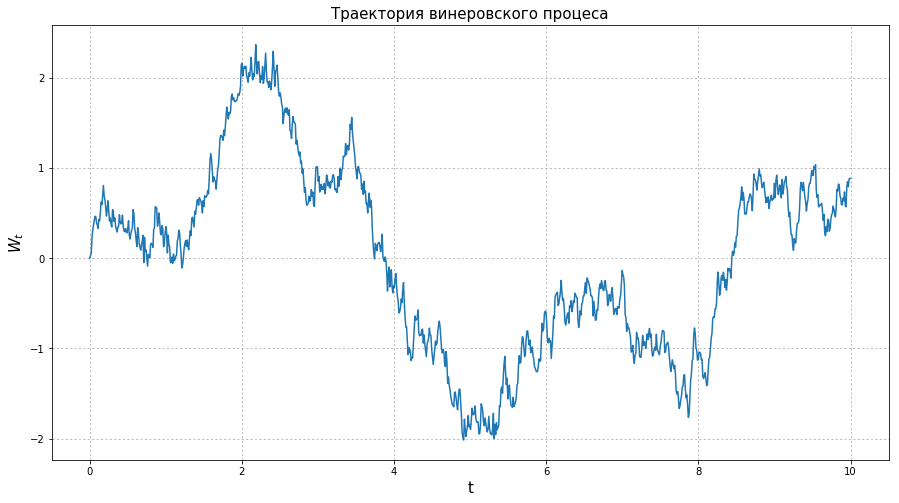

In [92]:
W = WinerProcess()
# W._log = True
T = np.linspace(0, 10, 1000)
plt.figure(figsize=(15, 8))
plt.plot(T, W[T])
plt.grid(ls=':')
plt.title("Траектория винеровского процеса", fontsize=15)
plt.xlabel("t", fontsize=15)
plt.ylabel("$W_t$", fontsize=15)
plt.show()

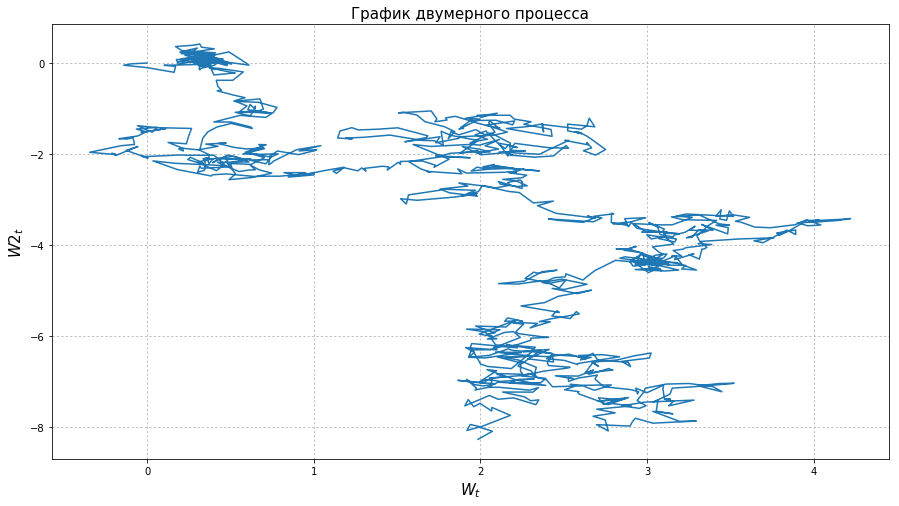

In [49]:
W2 = WinerProcess()
plt.figure(figsize=(15, 8))
plt.plot(W[T], W2[T])
plt.title("График двумерного процесса", fontsize=15)
plt.xlabel("$W_t$", fontsize=15)
plt.ylabel("$W2_t$", fontsize=15)
plt.grid(ls=':')
plt.show()

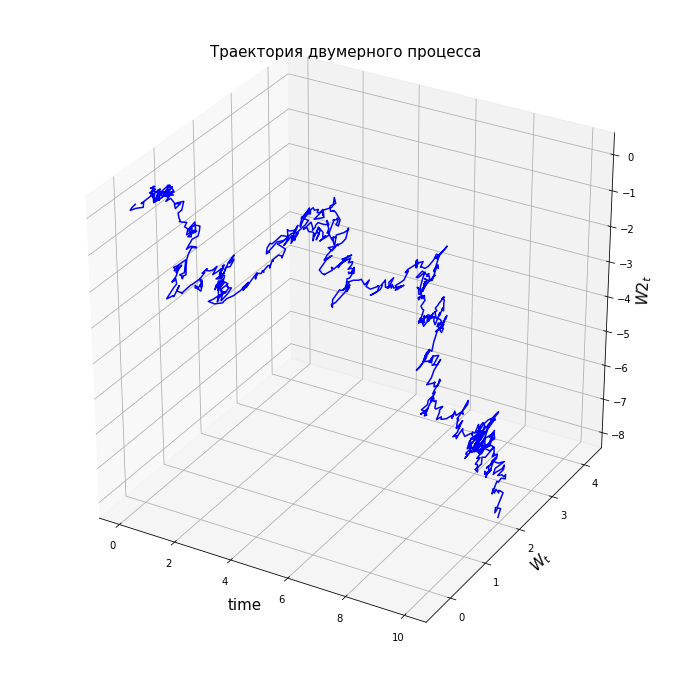

In [50]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
# ax.scatter(T, W[T], W2[T])
ax.plot(T, W[T], W2[T], color='b')
plt.title("Траектория двумерного процесса", fontsize=15)
ax.set_xlabel("time", fontsize=15)
ax.set_ylabel("$W_t$", fontsize=15)
ax.set_zlabel("$W2_t$", fontsize=15)
plt.show()

Допустим, для исследования свойств траекторий винеровского процесса нам нужно сгенерировать траекторию с хорошей точностью до достаточно большого значения $t$.
Какие проблемы могут возникнуть при использовании реализованного класса?
Для этого попробуйте запустить следующий код.

In [51]:
%time
try:
    Wt = WinerProcess()  # WinerProCCess()
    t = np.linspace(0, 10 ** 7, 10 ** 5)
    values = Wt[t]
except Exception as e:
    print("Catched exception = ", type(e))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15 µs
Catched exception =  <class 'MemoryError'>


Опишите подробно причину проблемы, которая в данном случае возникает.

**Описание:** Для моделирования процесса через функции Шаудера нужно precision случайных величин на каждый отрезок [0,1]. Итого, для точного моделирования нужно слишком много памяти, да и времени тоже.

При этом, если нам нужны значения только в целых точках, то из precision величин на каждом отрезке нас интересует только одна! (Та, у которой $S_k(1) \neq 0$, т.е. $\xi_0$).



Для избавления от таких проблем реализуйте следующую функцию:

**Примечание:** не просто скопируем, а перепишем код функции так, чтобы она не генерировала лишние $\xi_i, i \neq 0$ на тех отрезках [n, n+1], где не спрашивается значение. (см. комментарий выше)

In [103]:
def winer_process_path(end_time, step, precision=10000):
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    values = np.zeros_like(times)
    
    k = [0.5] + list(range(1, precision))
    n = np.log2(k).astype(int)
    a_nk = 2.**(- n)*(k - 2. ** n)
    
    # по сути это координаты x треугольников с рис 3.3 из книги
    positive_slope_l_bound = a_nk  # копирования не происходит, это python
    positive_slope_r_bound = a_nk + 2.**(-n - 1)

    negative_slope_l_bound = positive_slope_r_bound 
    negative_slope_r_bound = a_nk + 2.**(-n)

    # высоты и половинки оснований треугольников
    slope_height = 2. ** (- (n / 2.) - 1)
    slope_half_width = 2. ** (-n - 1)
    
    W = []

    Wt = 0. 
    last_int_t = 0
    # поддерживаем значение процесса в целой точке,
    # самой правой среди рассмотренных в массиве times
    # (предполагаем, что он отсортирован)

    xi = sps.norm.rvs(size=(precision))
    # поддерживаем xi_i, сгенерированные для отрезка [last_int_t, last_int_t + 1]
    
    
    for t in times:
        t_fractional_part = t - int(t)
        t_integer_part = int(t)
        
        if (t_integer_part > last_int_t):
            Wt += xi[0]
            last_int_t += 1
            
            if (t_integer_part - last_int_t - 1 > 0):
                xi0 = sps.norm.rvs(size=(t_integer_part - last_int_t - 1)) 
                # для отрезков времени [x, x+1], где не спрашивают значение,
                # генерируем только xi0, т.к. другие не нужны
                Wt += xi0.sum()

            last_int_t = t_integer_part
            xi = sps.norm.rvs(size=(precision))

        positive_slope = (
            (positive_slope_l_bound <= t_fractional_part)
            & (t_fractional_part <= positive_slope_r_bound)
        )
        # булевский вектор индексов positive_slope[k] - верно ли, что y S_k положительная
        # производная (или верхняя вершина треугольника - ф-ии Шаудера (рис 3.3)) в точке t
        # - т.е. мы находимся на "положительном склоне горы" (k>0)

        # S_k - k-ая функция Шаудера (согласно книге) 

        positive_slope[0] = False  # Sk[0] считается отдельно
            
        negative_slope = (
            (negative_slope_l_bound < t_fractional_part)
            & (t_fractional_part <= negative_slope_r_bound)
        )
        # аналогично для отрицательной производной "отрицательный склон горы - треугольника"
        # , но исключая "верх" треугольника (он уже был в positive_slope)

        Sk_in_positive_slopes = (
            slope_height[positive_slope]
            * (t_fractional_part - positive_slope_l_bound[positive_slope])
            / slope_half_width[positive_slope]
        )
        # вычислим значения только для тех функций, для которые производная 
        # в текущей точке положительна. (по подобию треугольников - см. рис. 3.3)

        Sk_in_negative_slopes = (
            slope_height[negative_slope]
            * (negative_slope_r_bound[negative_slope] - t_fractional_part)
            / slope_half_width[negative_slope]
        )
        # аналогично для negative_slopes

        W.append(Wt + xi[positive_slope] @ Sk_in_positive_slopes
                 + xi[negative_slope] @ Sk_in_negative_slopes
                 + xi[0] * t_fractional_part)
    return times, W

Заметим, что здесь гораздо более уместной (особенно по времени работы) кажется реализация через независимые приращения процесса (понятно, что мы не сможем так спросить у этого процесса значения ещё раз в каких-то новых точках, но это и не требуется).

In [104]:
def winer_process_path_alpha(end_time, step, precision=10000):
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    values = np.zeros_like(times)
    
    W_step = sps.norm(scale=np.sqrt(step)).rvs(len(times) - 1)  # независимые приращения
    values[1:] = np.cumsum(W_step)
    return times, values

Построим график с помощью функции, которая решает проблему.

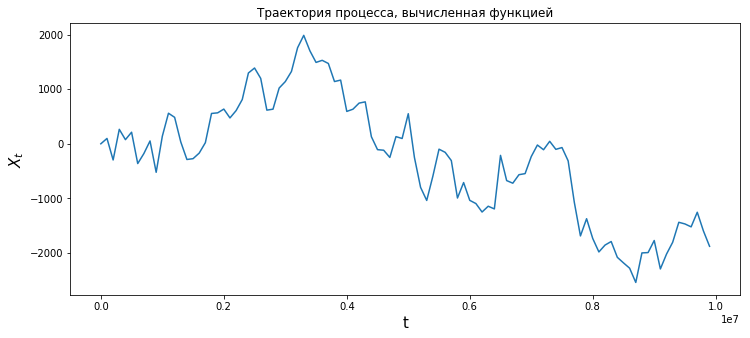

In [107]:
plt.figure(figsize=(12, 5))
plt.plot(*winer_process_path(10 ** 7, 10 ** 5))
plt.title("Траектория процесса, вычисленная функцией")
plt.ylabel("$X_t$", fontsize=15)
plt.xlabel("t", fontsize=15)
plt.show()

Для получения полного балла и быстро работающего кода реализация должна содержать не более одного явного цикла (по отрезкам при непосредственной генерации). Вместо всех остальных циклов нужно использовать функции библиотеки `numpy`. Внутри этой функции можно реализовать вспомогательную функцию.

### 2. Исследования

**Следующая часть работы делается в паре.**

Для каждого их двух способов генерация траектрии винеровского процесса постройте таблицу $3 \times 3$ из графиков траекторий винеровского процесса.
По вертикали изменяйте количество $n$ используемых слагаемых в сумме ($n=10; 100; 1000$), по горизонтали --- длину отрезка, на котором генерируется винеровский процесс (использовать отрезки $[0, 10], [0, 1], [0, 0.1]$).
Обратите внимание, что от размера сетки зависит только точность отображения функции на графике, а не сама функция, поэтому сетку нужно выбирать достаточно мелкой.

In [16]:
# код напарника
class WinerProcessSin:
    def __init__(self, precision=10000):
        self.N = precision
        self.ksi0 = [sps.norm.rvs(size=1)[0]]
        self.ksis = [[]]
        self.starts = [0]
        
    def __getitem__(self, times):
        times = np.array(times)
        if times.max() // np.pi >= len(self.ksi0):
            n_new = int(times.max() // np.pi) - len(self.ksi0) + 1
            new_ksi0 = sps.norm.rvs(size=n_new)
            self.starts.append(self.ksi0[-1] * np.sqrt(np.pi) + self.starts[-1])
            new_starts = np.cumsum(new_ksi0[:-1]) * np.sqrt(np.pi) + self.starts[-1]
            self.ksi0 += list(new_ksi0)
            self.starts += list(new_starts)
            self.ksis += [[] for i in range(n_new)]
        W = []
        for t in times:
            seg = int(t // np.pi)
            if len(self.ksis[seg]) == 0:
                self.ksis[seg] = sps.norm.rvs(size=self.N - 1)
            series_sum = np.sum(self.ksis[seg] * np.sin(np.arange(1, self.N)
                                * (t - seg * np.pi)) / np.arange(1, self.N))
            Wt = (self.starts[seg] + self.ksi0[seg] * (t - seg * np.pi) / np.sqrt(np.pi)
                                + series_sum * np.sqrt(2 / np.pi))
            W.append(Wt)
        return np.array(W)
    
def winer_process_path_sin(end_time, step, precision=10000):
    # Моменты времени, в которые нужно вычислить значения
    times = np.arange(0, end_time, step)
    # Сюда запишите значения траектории в моменты времени times
    values = [0]
    for t in times[:-1]:
        W = WinerProcessSin(precision=precision)
        values.append(W[[step]])
        del W
    values = np.cumsum(np.array(values))
    return times, values

Мой класс (Ф-ии Шаудера)


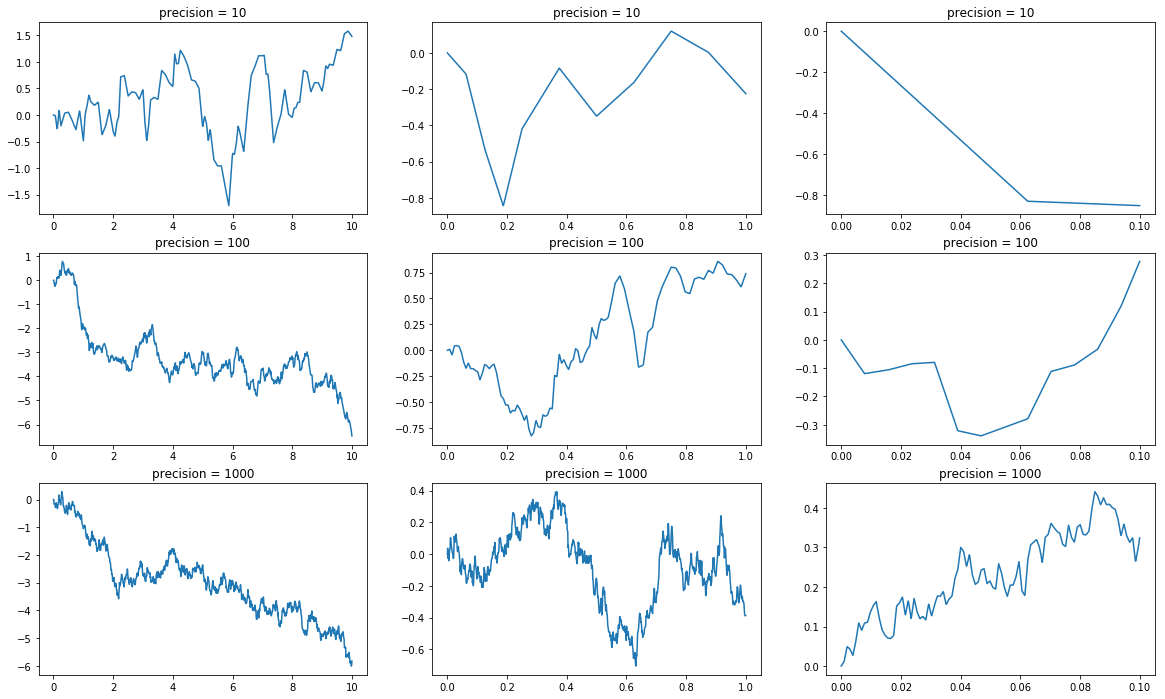

Класс напарника (ч-з синусы)


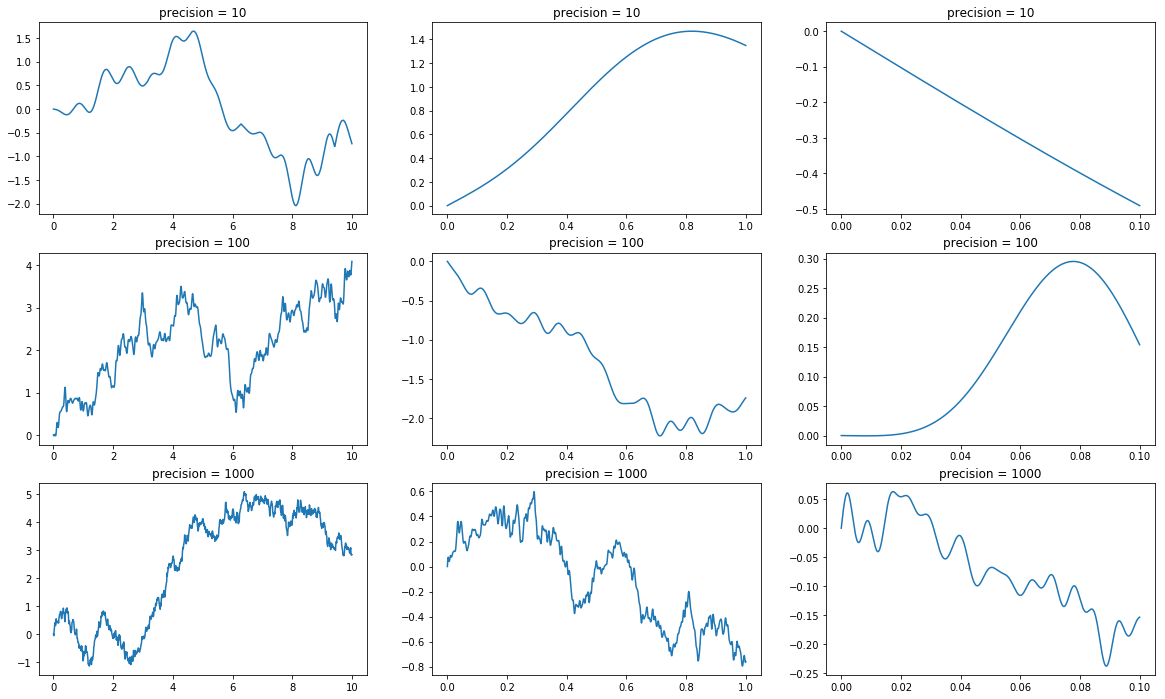

In [17]:
for WP, name in [(WinerProcess, "Мой класс (Ф-ии Шаудера)"),
                    (WinerProcessSin, "Класс напарника (ч-з синусы)")]:
    print(name)
    plt.figure(figsize=(20, 12))
    for i, precision in enumerate([10, 100, 1000]):
        for j, max_time in enumerate([10, 1, 0.1]):
            t = np.linspace(0, max_time, 1000)
            values = WP(precision=precision)[t]

            plt.subplot(3, 3, i * 3 + j + 1)
            plt.plot(t, values)
            plt.title('precision = %d' % precision)
    plt.show()

Сравните два способа генерации по времени работы.

In [76]:
%time times_shauder, values_shauder = winer_process_path(100000, 0.1)

CPU times: user 3min 6s, sys: 324 ms, total: 3min 6s
Wall time: 3min 7s


In [20]:
%time times_sin, values_sin = winer_process_path_sin(100000, 0.1)

CPU times: user 28min 34s, sys: 696 ms, total: 28min 34s
Wall time: 28min 36s


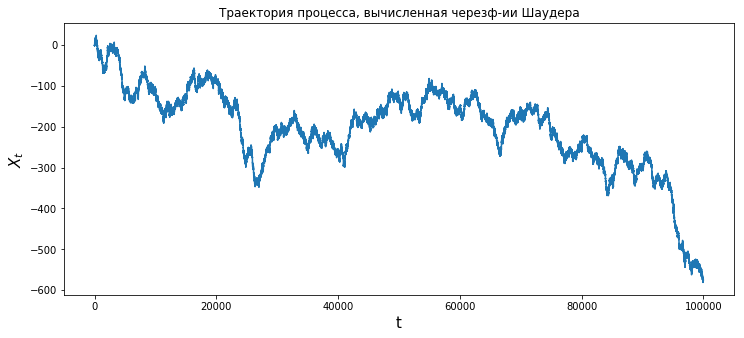

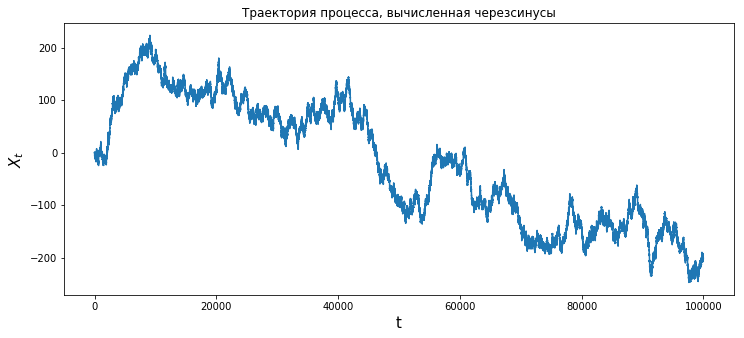

In [23]:
for times, values, name in [(times_shauder, values_shauder, "ф-ии Шаудера"),
                        (times_sin, values_sin, "синусы")]:
    plt.figure(figsize=(12, 5))
    plt.plot(times, values)
    plt.title("Траектория процесса, вычисленная через" + name)
    plt.ylabel("$X_t$", fontsize=15)
    plt.xlabel("t", fontsize=15)
    plt.show()

Кроме того, посмотрим, насколько быстрее работает тривиальная реализация.

In [24]:
%time times, values = winer_process_path_alpha(100000, 0.1)

CPU times: user 84 ms, sys: 36 ms, total: 120 ms
Wall time: 231 ms


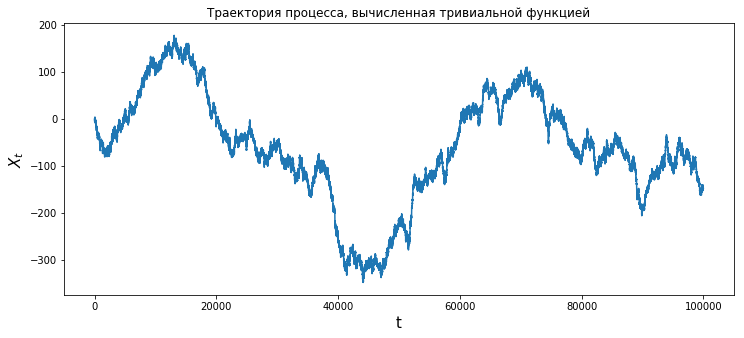

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(times, values)
plt.title("Траектория процесса, вычисленная тривиальной функцией")
plt.ylabel("$X_t$", fontsize=15)
plt.xlabel("t", fontsize=15)
plt.show()

Какие выводы можно сделать про каждый способ генерации?

Постройте графики полученных траекторий для каждого способа? Отличаются ли траектории визуально?

Какие можно сделать выводы из сравнения двух способов генерации?

**Вывод:** т.к. мы расматриваем не всю сумму, а только некоторый её префикс, по полученное приближение зависит от природы ортонормированной системы, которую мы используем. 

При использовании гладкой тригонометрической системы, приближение так же получается гладким. При использовании функций Хаара, приближение получается более ломанными и угловатым (и, субъективно, более похожим на винеровских процессов с семинара или с обложки учебного пособия).

В обоих случаях влияние метода и числа слагаемых уменьшается при росте рассматриваемого интервала (то, что на графиках выше - отрезок по горизонтальной (время) - [0, 10], [0, 1], [0, 0.1]) и/или при росте точности, что логично, т.е. становятся более похожими друг на друга и на презентации с семинара, лекции, т.е. на личное понимание графика траектории винеровского процесса.

Обговорим более подробно фразу "при росте рассматриваемого интервала". Как мы знаем, винеровский процесс самоподобен, и, при приближении графика (уменьшении интервала как по горизонтальной оси, так и по вертикальной) мы должны видеть подобную картинку, но мы видим соответственно ломанные (ф-ии Шаудера) или гладкие кривые (синусы). Такое поведение вполне очевидно, т.к. мы берём не абы какие слагаемые, а несколько первых, которые в обоих методах слабо подходят для быстрых изменений функции (в случае функций Шаудера - это треугольники с некоторый высотой и убывающей шириной основания - кусочно линейная функция вообще). Таким образом, для большого масштаба достаточно взять лишь несколько слагаемых, но для малого - нужно много слагаемых , т.к. при увеличении наше приближение выглядит как линия и ни о каком самоподобии речь не идёт. (например, для функций Шаудера, можно взять одно слагаемое, если нас интересуют значения в моменты времени, когда t - натуральное число, при этом это будет не приближение, а точные значения, т.к. бесконечная сумма в точках 0 и 1 превращается в одно слагаемое - это верно для обоих методов)

Касательно скорости работы, т.к. функция Шаудера вычисляется несколько сложнее функции sin (и, что важно, менее нативно),
то метод с вычислением через синусы должен выигрывать по времени, но он проигрывает и вычисление через функции Шаудера работает значительно быстрее, хотя что-то мне подсказывает, что это из-за проблем с реализацией второго решения. С другой стороны, для функции шаудера только $O(log(precision))$ слагаемых в формуле для каждой точки не нулевые (для того, чтобы убедится в этом нужно всего лишь понять, как строятся функции Шаудера, например, нарисовать графики первых $2^k$ функций друг под другом - это будет что-то похожее на дерево отрезков - полное двоичное дерево, в каждом слое которого отрезок [0,1] поделён на 2^k частей), что упрощает генерацию - используя этот факт, можно написать алгоритм, который ищет значение траектории процесса в точке не за $O(precision)$, а за $O(log(precision))$

**Следующая часть работы делается индивидуально.**

1. Сгенерируйте 100 траекторий винеровского процесса с достаточно хорошей точностью и нарисуйте их на одном графике? Что можно сказать про поведение траекторий?

2. Нарисуйте график двумерного винеровского процесса (см. презентацию с семинара).

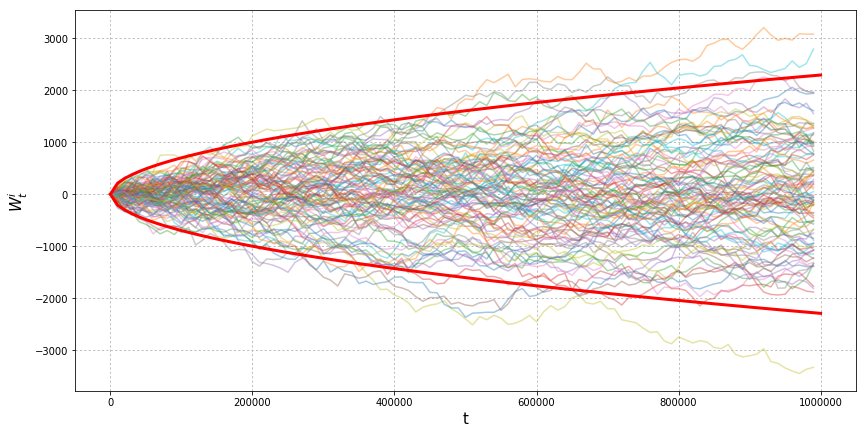

In [43]:
plt.figure(figsize=(14, 7))
max_time = 1000000
grid = np.linspace(np.e, max_time, 100)
for i in range(100):
    # print(i, end=",")
    times, values = winer_process_path(max_time, 10000)
    plt.plot(times, values, alpha=0.4)
plt.grid(ls=':')    
upper = np.sqrt(2 * grid * np.log(np.log(grid)))
lower = -np.sqrt(2 * grid * np.log(np.log(grid)))
plt.plot(grid, upper, color='red', lw=3)
plt.plot(grid, lower, color='red', lw=3)
plt.xlabel("t", fontsize=15)
plt.ylabel("$W_t^i$", fontsize=15)
plt.show()

**Комментарий:** Наблюдаем картину, которую рисуют при формулировке закона повторного логарифма (кривые из условия обозначены красным), что подтверждает его верность. Заметим, что только три процесса из 100 вышли за эту кривую для последнего момента времени. Более того, многие кривые расположены близко к этой кривой с внутренней стороны, что подтверждает утверждение о том, что процесс будет бесконечно много раз выходить из области, ограниченной кривыми $y = \pm (1 - \varepsilon)\sqrt{2 t\ \ln(\ln t)}, \forall \varepsilon > 0$ (на лекции было озаглавлено как "смысл ЗПЛ")

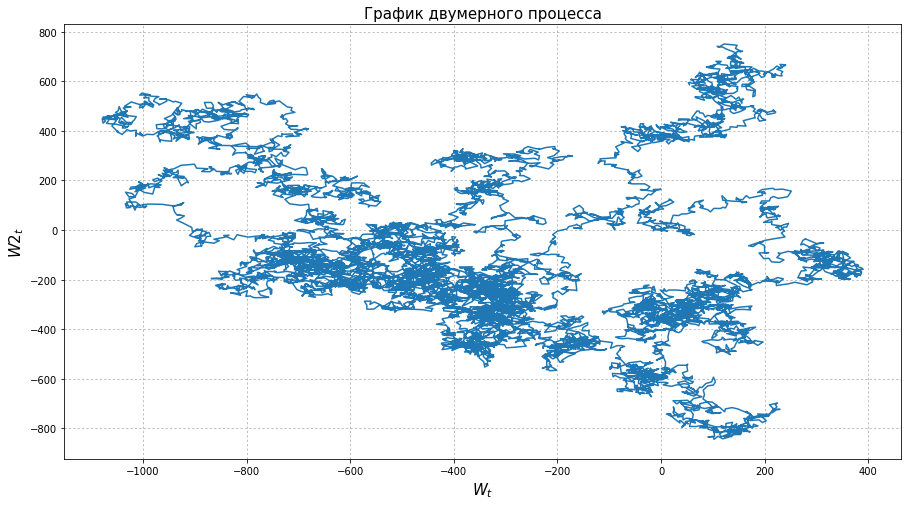

In [45]:
times, values_1 = winer_process_path(max_time, 100)
times, values_2 = winer_process_path(max_time, 100)

plt.figure(figsize=(15, 8))
plt.plot(values_1, values_2)
plt.title("График двумерного процесса", fontsize=15)
plt.xlabel("$W_t$", fontsize=15)
plt.ylabel("$W2_t$", fontsize=15)
plt.grid(ls=':')
plt.show()

**Комментарий:** Видим, что двумерный винеровский процесс напоминает рисунок, который изображают при рассказе о броуновском движении, из-за чего виннеровский процесс и имеет такое второе название.